# 解析数据

In [1]:
import sys
import cPickle as pickle

if sys.version_info.major != 2 or sys.version_info.minor != 7:
    print 'Need run on Python2.7.x'
    sys.exit(-1)

# categories
category = {'a1':['Art','Architecture','Classics','Cultural Studies','Dance','Folklore','History','History & Philosophy of Science','Humanities, Multidisciplinary','Language & Linguistics','Linguistics','Literary Reviews','Literary Theory & Criticism','Literature','Literature, African, Australian, Canadian','Literature, American','Literature, British Isles','Literature, German, Dutch, Scandanavian','Literature, Romance','Literature, Slavic','Medieval & Renaissance Studies','Music','Philosophy','Poetry','Religion','Theater'],
            'c2':['Allergy','Anesthesiology','Audiology & Speech-Language Pathology','Cardiac & Cardiovascular Systems','Clinical Neurology','Critical Care Medicine','Dentistry, Oral Surgery & Medicine','Dermatology','Emergency Medicine','Endocrinology & Metabolism','Gastroenterology & Hepatology','Geriatrics & Gerontology','Health Care Sciences & Services','Hematology','Infectious Diseases','Integrative & Complementary Medicine','Medical Ethics','Medical Informatics','Medical Laboratory Technology','Medicine, General & Internal','Medicine, Legal','Medicine, Research & Experimental','Neuroimaging','Nursing','Nutrition & Dietetics','Obstetrics & Gynecology','Oncology','Ophthalmology','Orthopedics','Otorhinolaryngology','Pathology','Pediatrics','Peripheral Vascular Disease','Pharmacology & Pharmacy','Primary Health Care','Psychiatry','Public, Environmental & Occupational Health','Radiology, Nuclear Medicine & Medical Imaging','Rehabilitation','Respiratory System','Rheumatology','Sport Sciences','Substance Abuse','Surgery','Transplantation','Tropical Medicine','Urology & Nephrology'],
            'e3':['Acoustics','Automation & Control Systems','Computer Science, Artificial Intelligence','Computer Science, Cybernetics','Computer Science, Hardware & Architecture','Computer Science, Information Systems','Computer Science, Interdisciplinary Applications','Computer Science, Software Engineering','Computer Science, Theory & Methods','Construction & Building Technology','Energy & Fuels','Engineering, Aerospace','Engineering, Biomedical','Engineering, Chemical','Engineering, Civil','Engineering, Electrical & Electronic','Engineering, Environmental','Engineering, Geological','Engineering, Industrial','Engineering, Manufacturing','Engineering, Marine','Engineering, Mechanical','Engineering, Multidisciplinary','Engineering, Ocean','Engineering, Petroleum','Ergonomics','Imaging Science & Photographic Technology','Information Science & Library Science','Instruments & Instrumentation','Materials Science, Biomaterials','Materials Science, Ceramics','Materials Science, Characterization & Testing','Materials Science, Composites','Materials Science, Multidisciplinary','Materials Science, Paper & Wood','Materials Science, Coatings & Films','Materials Science, Textiles','Mechanics','Metallurgy & Metallurgical Engineering','Microscopy','Mining & Mineral Processing','Nuclear Science & Technology','Operations Research & Management Science','Remote Sensing','Robotics','Telecommunications','Transportation','Transportation Science & Technology'],
            'l4':['Agricultural Economics & Policy','Agricultural Engineering','Agriculture, Dairy & Animal Science','Agriculture, Multidisciplinary','Agronomy','Anatomy & Morphology','Andrology','Behavioral Sciences','Biochemical Research Methods','Biochemistry & Molecular Biology','Biodiversity Conservation','Biology','Biophysics','Biotechnology & Applied Microbiology','Cardiac & Cardiovascular Systems','Cell & Tissue Engineering','Cell Biology','Developmental Biology','Ecology','Endocrinology & Metabolism','Entomology','Environmental Sciences','Evolutionary Biology','Fisheries','Food Science & Technology','Forestry','Gastroenterology & Hepatology','Genetics & Heredity','Horticulture','Immunology','Limnology','Marine & Freshwater Biology','Mathematical & Computational Biology','Microbiology','Multidisciplinary Sciences','Mycology','Neurosciences','Oncology','Ornithology','Paleontology','Parasitology','Pathology','Peripheral Vascular Disease','Pharmacology & Pharmacy','Physiology','Plant Sciences','Reproductive Biology','Soil Science','Toxicology','Transplantation','Veterinary Sciences','Virology','Zoology'],
            'p5':['Astronomy & Astrophysics','Astronomy/Astrophysics', 'Chemistry, Analytical','Chemistry, Applied','Chemistry, Inorganic & Nuclear','Chemistry, Medicinal','Chemistry, Multidisciplinary','Chemistry, Organic','Chemistry, Physical','rystallography','Electrochemistry','Geochemistry & Geophysics','Geography, Physical','Geology','Geosciences, Multidisciplinary','Logic','Mathematics','Mathematics, Applied','Mathematics, Interdisciplinary Applications','Meteorology & Atmospheric Sciences','Mineralogy','Multidisciplinary Sciences','Nanoscience & Nanotechnology','Oceanography','Optics','Physics, Applied','Physics, Atomic, Molecular & Chemical','Physics, Condensed Matter','Physics, Fluids & Plasmas','Physics, Mathematical','Physics, Multidisciplinary','Physics, Nuclear','Physics, Particles & Fields','Polymer Science','Spectroscopy','Statistics & Probability','Thermodynamics','Water Resources'],
            's6':['Anthropology','Archaeology','Area Studies','Asian Studies','Business','Business, Finance','Communication','Criminology & Penology','Demography','Economics','Education & Educational Research','Education, Scientific Disciplines','Education, Special','Environmental Studies','Ethics','Ethnic Studies','Family Studies','Film, Radio, Television','Geography','Gerontology','Health Policy & Services','History of Social Sciences','Hospitality, Leisure, Sport & Tourism','Industrial Relations & Labor','International Relations','Law','Linguistics','Management','Planning & Development','Political Science','Psychology','Psychology, Applied','Psychology, Biological','Psychology, Clinical','Psychology, Developmental','Psychology, Educational','Psychology, Experimental','Psychology, Mathematical','Psychology, Multidisciplinary','Psychology, Psychoanalysis','Psychology, Social','Public Administration','Social Issues','Social Sciences, Biomedical','Social Sciences, Interdisciplinary','Social Sciences, Mathematical Methods','Social Work','Sociology','Urban Studies','Women‘s Studies', "Women's Studies"]}

big2small = {}
for key, values in category.iteritems():
    values = map(str.lower, values)
    big2small[key] = values

small2big = {}
for key, values in big2small.iteritems():
    for v in values:
        small2big[v] = key

####################   result format   #########################
# {'paper_wos_id':                                             #
#           {'pub_year': int,                                  #
#            'small_fields': [small1, small2, ..],             #
#            'big_fields': [big1, big2, ..],                   #
#            'cite_info': {year_offset:cite_num, ...},         #
#            'ref_info': {year_offset:ref_num, ...}            #
#           }, ...                                             #
# }                                                            #
################################################################
result = {}

### parse 7955paper_info.txt ###
print 'parsing 7955paper_info.txt'
small_fields = None
big_fields = None
pub_year = None
paper_cnt = 0
fp = open('./7955paper_info.txt')
lines = fp.readlines()
line_idx = 0
while line_idx < len(lines):
    line = lines[line_idx].strip()
    if line.startswith('PT '): # ATTENTION, the blank MUST be reserved
        paper_cnt += 1
        # print 'Proccesing {}-th parer'.format(paper_cnt)
        line_idx += 1
    elif line.startswith('PY '): # VERY IMPORTANT, but may not reasonable in case of cite/ref year, how to fix!!
        pub_year = int(line[3:])
        line_idx += 1
    elif line.startswith('WC '):  # may have multi-lines
        wcs = line[3:]
        line_idx += 1
        while lines[line_idx].startswith(' '):
            wcs += ' '+lines[line_idx].strip()
            line_idx += 1
        small_fields = [item.lower().strip() for item in wcs.split(';') if item.strip()] # possible multi-small-fields
        big_fields = [small2big.get(sf, None) for sf in small_fields] # possible multi-big-fields
        big_fields = [bf for bf in big_fields if bf != None]
        # if len(big_fields) <= 0:
        #     print small_fields
        #     print big_fields
        #     print 'error, no big-field: {}'.format(wcs)
    elif line.startswith('UT '):
        try:
            _, paper_wos_id = line.lower().split(':')
            if paper_wos_id not in result: # paper_wos_id is unique, so it should always not in result
                if len(big_fields) > 0:
                    result[paper_wos_id] = {'pub_year': pub_year, 'small_fields': small_fields, 'big_fields': big_fields}
            else:
                print 'error, duplicated paper_wos_id: {}'.format(line)
        except Exception as e:
            print e
            print 'error, no UT: {}'.format(line)
        line_idx += 1
    else:
        line_idx += 1
fp.close()
print 'Amount papers: {}'.format(paper_cnt)


### parse fifth_citing.txt ###
print 'parsing fifth_citing.txt'
last_paper_wos_id = ''
last_cite_paper_wos_id = set()
paper_cite_infos = {}
paper_cnt_in_cite = 0
paper_cite_before_pub_year_cnt = 0
with open('./fifth_citing.txt') as fp:
    next(fp) # skip first line
    for line in fp:
        items = line.strip().split('======')
        if len(items) != 4:
            print 'error, {}'.format(line.strip())
            continue
        paper_wos_id      = items[0].split(':')[1]
        cite_paper_field  = items[1]                             # ATTENTION: we may can use this paper_field to decide it's big-field
        cite_paper_wos_id = items[2].split(':')[1]
        cite_paper_year   = int(items[3])

        if last_paper_wos_id != paper_wos_id:
            if last_paper_wos_id != '':
                if last_paper_wos_id in result:
                    if len(paper_cite_infos) > 0:
                        if result[last_paper_wos_id].has_key('cite_info'):
                            for k, v in paper_cite_infos.iteritems():
                                if k in result[last_paper_wos_id]['cite_info']:
                                    result[last_paper_wos_id]['cite_info'][k] += v
                                else:
                                    result[last_paper_wos_id]['cite_info'][k] = v
                        else:
                            result[last_paper_wos_id]['cite_info'] = paper_cite_infos

            last_paper_wos_id = paper_wos_id
            last_cite_paper_wos_id = set()
            paper_cite_infos = {}
            paper_cnt_in_cite += 1

        if paper_wos_id in result:
            if cite_paper_wos_id not in last_cite_paper_wos_id:
                last_cite_paper_wos_id.add(cite_paper_wos_id)
                year_offset = cite_paper_year - result[paper_wos_id]['pub_year']
                if year_offset < 0:
                    paper_cite_before_pub_year_cnt += 1
                if year_offset in paper_cite_infos:
                    paper_cite_infos[year_offset] += 1
                else:
                    paper_cite_infos[year_offset] = 1

    if paper_wos_id in result:
        if len(paper_cite_infos) > 0:
            result[paper_wos_id]['cite_info'] = paper_cite_infos

print 'paper_cnt_in_cite: {}'.format(paper_cnt_in_cite)
print 'paper_cite_before_pub_year_cnt: {}'.format(paper_cite_before_pub_year_cnt)


### parse fifth_ref.txt ###
print 'parsing fifth_ref.txt'
last_paper_wos_id = ''
last_ref_paper_wos_id = set()
paper_ref_infos = {}
paper_cnt_in_ref = 0
paper_ref_after_pub_year_cnt = 0
cnt = 0
with open('yibu/fifth_ref.txt') as fp:
    next(fp) # skip first line
    for line in fp:
        items = line.strip().split('======')
        if len(items) != 4:
            print 'error, {}'.format(line.strip())
            continue
        paper_wos_id     = items[0].split(':')[1]
        ref_paper_field  = items[1]
        ref_paper_wos_id = items[2].split(':')[1]
        ref_paper_year   = int(items[3])

        if last_paper_wos_id != paper_wos_id:
            if last_paper_wos_id != '':
                if last_paper_wos_id in result:
                    if len(paper_ref_infos) > 0:
                        if result[last_paper_wos_id].has_key('ref_info'):
                            for k, v in paper_ref_infos.iteritems():
                                if k in result[last_paper_wos_id]['ref_info']:
                                    result[last_paper_wos_id]['ref_info'][k] += v
                                else:
                                    result[last_paper_wos_id]['ref_info'][k] = v
                        else:
                            result[last_paper_wos_id]['ref_info'] = paper_ref_infos

            last_paper_wos_id = paper_wos_id
            last_ref_paper_wos_id = set()
            paper_ref_infos = {}
            paper_cnt_in_ref += 1

        if paper_wos_id in result:
            if ref_paper_wos_id not in last_ref_paper_wos_id:
                last_ref_paper_wos_id.add(ref_paper_wos_id)
                year_offset = result[paper_wos_id]['pub_year'] - ref_paper_year
                if year_offset < 0:
                    paper_ref_after_pub_year_cnt += 1
                if year_offset in paper_ref_infos:
                    paper_ref_infos[year_offset] += 1
                else:
                    paper_ref_infos[year_offset] = 1

    if paper_wos_id in result:
        if len(paper_ref_infos) > 0:
            result[paper_wos_id]['ref_info'] = paper_ref_infos

print 'paper_cnt_in_ref: {}'.format(paper_cnt_in_ref)
print 'paper_ref_after_pub_year_cnt: {}'.format(paper_ref_after_pub_year_cnt)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(int 'Need run on Python2.7.x')? (<ipython-input-1-b8b0be69a7ab>, line 5)

# 提取画图数据

In [3]:
from __future__ import division
import numpy as np
from collections import defaultdict

####################   plot_datas format   ###################################
# {'SOME_KEY': [                                                             #
#                 [(offset1, cum_cite_num1), (offset2, cum_cite_num2), ...], #
#                 ...                                                        #
#                ],                                                          #
# }                                                                          #
##############################################################################

### extracting ploting datas, SOME_KEY=big_fields/ref_num_type/price_index_type
plot_datas1 = defaultdict(list)
plot_datas2 = defaultdict(list)
plot_datas3 = defaultdict(list)
cnt = 0
for key, infos in result.iteritems():
#     if cnt > 500:
#         break
    paper_wos_id = key
    big_fields = infos['big_fields']
    pub_year = infos['pub_year']
    if not infos.has_key('cite_info') or not infos.has_key('ref_info'):
        continue

    cite_info = infos['cite_info']
    cite_info = sorted(cite_info.iteritems(), key=lambda x:x[0]) # [(offset1, cite_num), (offset2, cite_num), ...]
    ref_info = infos['ref_info']
    ref_info = sorted(ref_info.iteritems(), key=lambda x:x[0])

    # one record #
    offsets, cite_nums = zip(*cite_info)
    cum_cite_nums = np.cumsum(cite_nums)
    cum_cite_nums_ratios = np.cumsum(cite_nums) / float(np.sum(cite_nums))
    one_record = zip(offsets, cum_cite_nums_ratios)
    
    amount_ref_num = sum(zip(*ref_info)[1])
    last_five_year_ref_num = sum([ref_num for year_offset, ref_num in ref_info if -5 <= year_offset <= 5]) # ATTENTION: maybe need to change to 4
    price_index = last_five_year_ref_num*1.0 / amount_ref_num
    
    if amount_ref_num <= 21:
        plot_datas2['Limited knowledge'].append(one_record)
    elif 22 <= amount_ref_num <= 41:
        plot_datas2['Moderate knowledge'].append(one_record)
    elif amount_ref_num >= 42:
        plot_datas2['High knowledge'].append(one_record)
    
    if price_index <= 0.43:
        plot_datas3['Earlier knowledge'].append(one_record)
    elif 0.44 <= price_index <= 0.71:
        plot_datas3['Appropriate knowledge'].append(one_record)
    elif price_index >= 0.72:
        plot_datas3['Recent knowledge'].append(one_record)

    for bf in big_fields:
        plot_datas1[bf].append(one_record)

    cnt += 1
print 'Amount papers: {}'.format(cnt)

Amount papers: 7927


# 画图

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

## 按领域划分的图

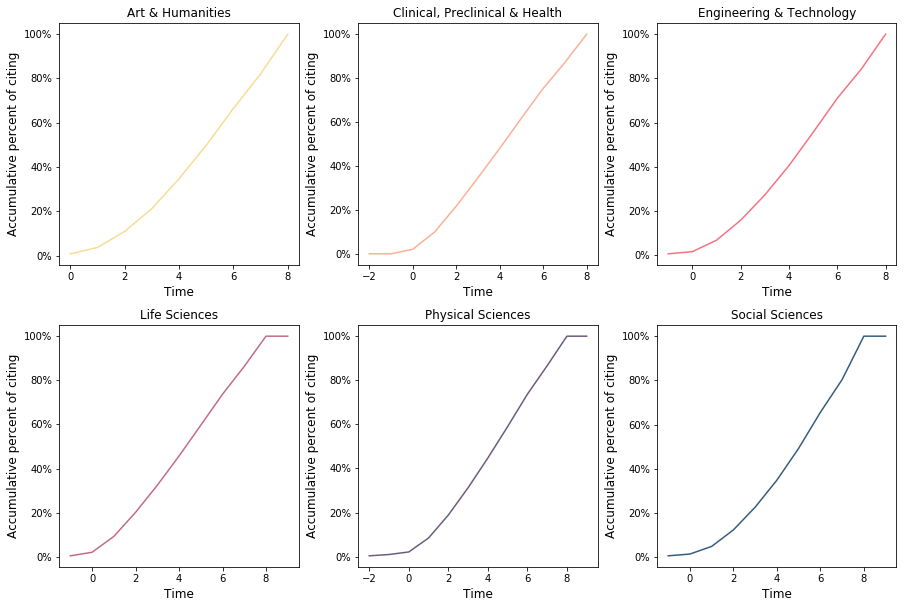

In [14]:
big_fields = ['a1', 'c2', 'e3', 'l4', 'p5', 's6']
big_fields_complete = {'a1': 'Art & Humanities',
                       'c2': 'Clinical, Preclinical & Health',
                       'e3': 'Engineering & Technology',
                       'l4': 'Life Sciences',
                       'p5': 'Physical Sciences',
                       's6': 'Social Sciences'
                      }

# plotting 2*3
rows = 2
cols = 3
# https://color.adobe.com/zh/explore/?filter=most-popular&time=month
colors = ['#F8DC94', '#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D']
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
for row in range(rows):
    for col in range(cols):
        bf = big_fields[row*cols+col]
        datas = plot_datas1[bf]
        ax = axes[row][col]
        all_datas = {}
        for d in datas:
            #xs, ys = zip(*d)
            #ax.plot(xs, ys, color=colors[row*cols+col])
            for x, y in d:
                if x in all_datas:
                    all_datas[x].append(y)
                else:
                    all_datas[x] = [y]
        xs = []
        ys = []
        for k, v in all_datas.iteritems():
            xs.append(k)
            ys.append(np.mean(v))
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda x:x[0]))
        ax.plot(xs, ys, color=colors[row*cols+col])
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Accumulative percent of citing', fontsize=12)
        ax.set_title('{}'.format(big_fields_complete[bf]), fontsize=12)
        # ax.annotate('{}'.format(big_fields_complete[bf]), xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_big_fields.png')

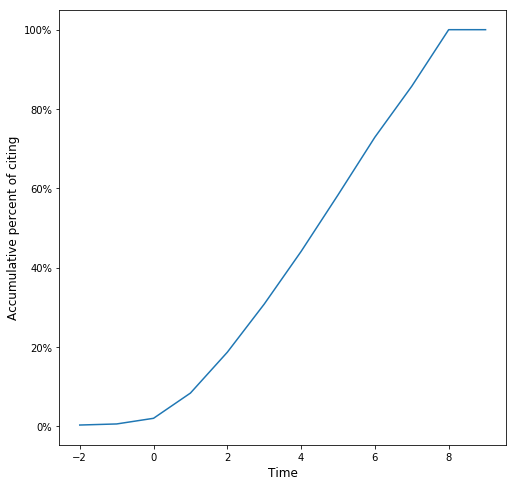

In [8]:
# plotting 1*1
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
all_datas = {}
for bf in big_fields:
    datas = plot_datas1[bf]
    for d in datas:
        # xs, ys = zip(*d)
        #ax.plot(xs, ys)
        for x, y in d:
            if x in all_datas:
                all_datas[x].append(y)
            else:
                all_datas[x] = [y]
xs = []
ys = []
for k, v in all_datas.iteritems():
    xs.append(k)
    ys.append(np.mean(v))
xs, ys = zip(*sorted(zip(xs, ys), key=lambda x:x[0]))
ax.plot(xs, ys)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Accumulative percent of citing', fontsize=12)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_big_fields_whole.png')

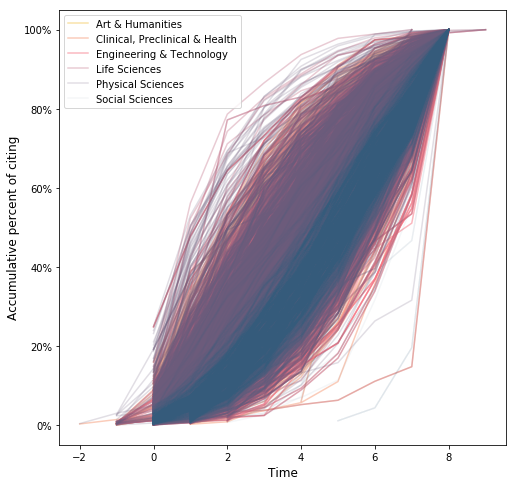

In [6]:
# plotting 1*1
alphas = [0.8, 0.65, 0.5, 0.35, 0.2, 0.05]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plots = []
for idx, bf in enumerate(big_fields):
    datas = plot_datas1[bf]
    for d in datas:
        xs, ys = zip(*d)
        pp = ax.plot(xs[:10], ys[:10], color=colors[idx], alpha=alphas[idx]) # pp is a list of plot-handles, but only contain one handle
    plots.append(pp[0]) # pp[0], get the plot-handle
    
plt.legend(handles=plots, labels=[big_fields_complete[bf] for bf in big_fields], loc='upper left')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Accumulative percent of citing', fontsize=12)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.savefig('result_big_fields_whole_2.png')

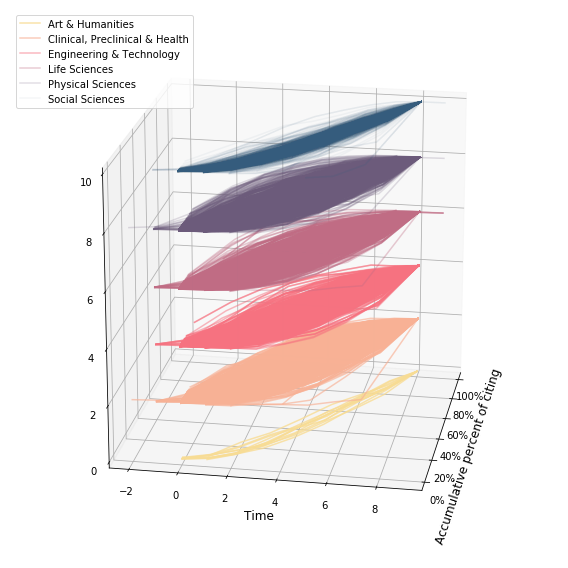

In [7]:
# plotting 1*1
from mpl_toolkits.mplot3d import axes3d

alphas = [0.8, 0.65, 0.5, 0.35, 0.2, 0.05]
zs = [0, 2, 4, 6, 8, 10]
plots = []
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for idx, bf in enumerate(big_fields):
    datas = plot_datas1[bf]
    for d in datas:
        xs, ys = zip(*d)
        pp = ax.plot3D(ys, xs, zs[idx], color=colors[idx], alpha=alphas[idx])
    plots.append(pp[0])

plt.legend(handles=plots, labels=[big_fields_complete[bf] for bf in big_fields], loc='upper left')
ax.set_ylabel('Time', fontsize=12)
ax.set_xlabel('Accumulative percent of citing', fontsize=12)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.invert_xaxis()
ax.view_init(20, 10) #left-right-angle, up-down-angle
fig.tight_layout()
plt.savefig('result_big_fields_whole_3d.png')

## 按参考文献数量画图

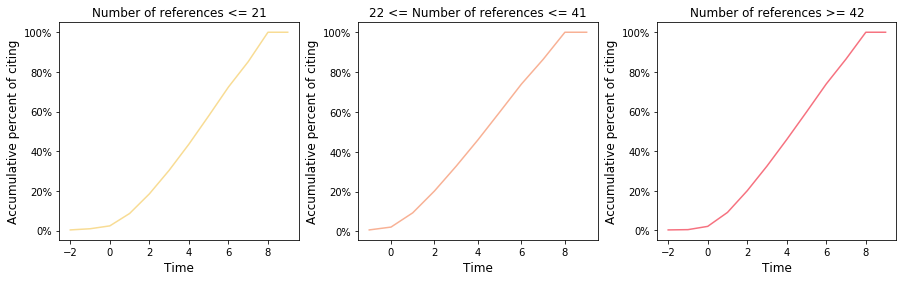

In [9]:
# plotting 1*3
partitions = ['reference']
types = ['Limited knowledge', 'Moderate knowledge', 'High knowledge']
type2title = {'Limited knowledge':'Number of references <= 21',
              'Moderate knowledge':'22 <= Number of references <= 41',
              'High knowledge':'Number of references >= 42'}

# https://color.adobe.com/zh/explore/?filter=most-popular&time=month
colors = ['#F8DC94', '#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D']
fig, axes = plt.subplots(len(partitions), len(types), figsize=(15, 4))
for row, _ in enumerate(partitions):
    for col, type_ in enumerate(types):
        all_datas = {}
        datas = plot_datas2[type_]
        ax = axes[row*len(types)+col]
        for d in datas:
            #xs, ys = zip(*d)
            #ax.plot(xs, ys, color=colors[row*len(types)+col])
            for x, y in d:
                if x in all_datas:
                    all_datas[x].append(y)
                else:
                    all_datas[x] = [y]
        xs = []
        ys = []
        for k, v in all_datas.iteritems():
            xs.append(k)
            ys.append(np.mean(v))
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda x:x[0]))
        ax.plot(xs, ys, color=colors[row*len(types)+col])
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Accumulative percent of citing', fontsize=12)
        ax.set_title(type2title[type_], fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_ref_num.png')

## 按普莱斯指数画图

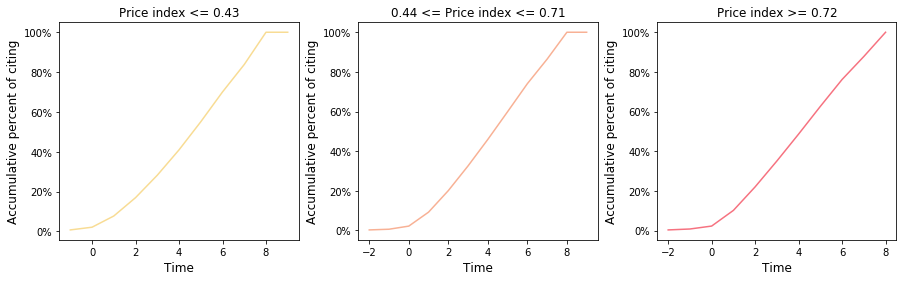

In [12]:
partitions = ['price index']
types = ['Earlier knowledge', 'Appropriate knowledge', 'Recent knowledge']
type2title = {'Earlier knowledge':'Price index <= 0.43',
              'Appropriate knowledge':'0.44 <= Price index <= 0.71',
              'Recent knowledge':'Price index >= 0.72'}

# https://color.adobe.com/zh/explore/?filter=most-popular&time=month
colors = ['#F8DC94', '#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D']
fig, axes = plt.subplots(len(partitions), len(types), figsize=(15, 4))
for row, _ in enumerate(partitions):
    for col, type_ in enumerate(types):
        all_datas = {}
        datas = plot_datas3[type_]
        ax = axes[row*len(types)+col]
        for d in datas:
            #xs, ys = zip(*d)
            #ax.plot(xs, ys, color=colors[row*len(types)+col])
            for x, y in d:
                if x in all_datas:
                    all_datas[x].append(y)
                else:
                    all_datas[x] = [y]
        xs = []
        ys = []
        for k, v in all_datas.iteritems():
            xs.append(k)
            ys.append(np.mean(v))
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda x:x[0]))
        ax.plot(xs, ys, color=colors[row*len(types)+col])
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Accumulative percent of citing', fontsize=12)
        ax.set_title(type2title[type_], fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_price_index.png')

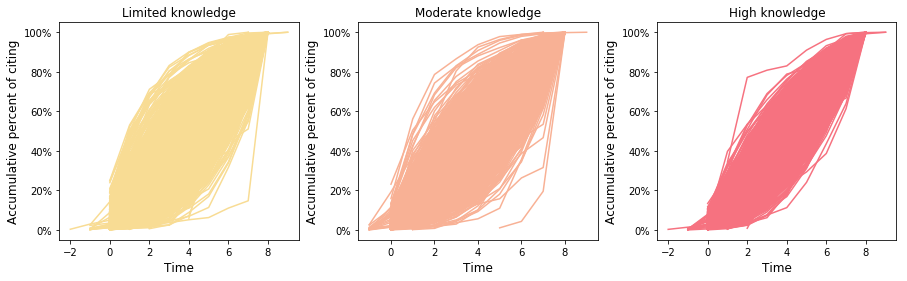

In [10]:
# plotting 1*3
partitions = ['reference']
types = ['Limited knowledge', 'Moderate knowledge', 'High knowledge']
type2title = {'Limited knowledge':'Number of references <= 21',
              'Moderate knowledge':'22 <= Number of references <= 41',
              'High knowledge':'Number of references >= 42'}

# https://color.adobe.com/zh/explore/?filter=most-popular&time=month
colors = ['#F8DC94', '#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D']
fig, axes = plt.subplots(len(partitions), len(types), figsize=(15, 4))
for row, _ in enumerate(partitions):
    for col, type_ in enumerate(types):
        datas = plot_datas2[type_]
        ax = axes[row*len(types)+col]
        for d in datas:
            xs, ys = zip(*d)
            ax.plot(xs, ys, color=colors[row*len(types)+col])
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Accumulative percent of citing', fontsize=12)
        ax.set_title(type_, fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_ref_num_2.png')

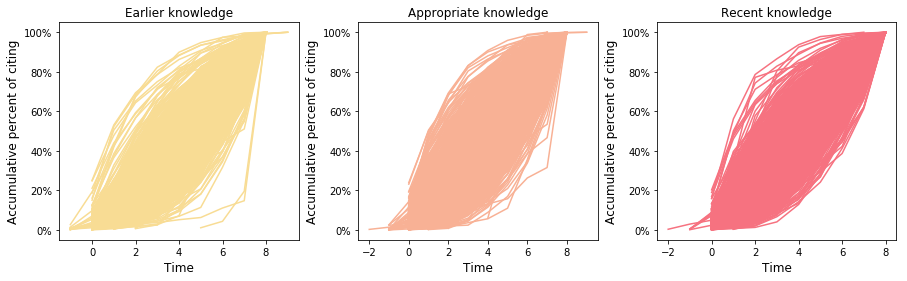

In [11]:
partitions = ['price index']
types = ['Earlier knowledge', 'Appropriate knowledge', 'Recent knowledge']
type2title = {'Earlier knowledge':'Price index <= 0.43',
              'Appropriate knowledge':'0.44 <= Price index <= 0.71',
              'Recent knowledge':'Price index >= 0.72'}

# https://color.adobe.com/zh/explore/?filter=most-popular&time=month
colors = ['#F8DC94', '#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D']
fig, axes = plt.subplots(len(partitions), len(types), figsize=(15, 4))
for row, _ in enumerate(partitions):
    for col, type_ in enumerate(types):
        datas = plot_datas3[type_]
        ax = axes[row*len(types)+col]
        for d in datas:
            xs, ys = zip(*d)
            ax.plot(xs, ys, color=colors[row*len(types)+col])
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Accumulative percent of citing', fontsize=12)
        ax.set_title(type_, fontsize=12)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('result_price_index_2.png')